## Environment preparation

In [1]:
import sys
sys.path.append('../src')

import os
import gc
import bcolz
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, History
from itertools import chain
import random
import vgg16
import data_helper
from data_helper import Preprocessor
from vgg16 import MyNet


os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

# Let pandas to print full name of data contents, instead of 'blah...'
pd.set_option('display.max_colwidth', -1)

tf.__version__

# Data input
destination_path = "../input/"
is_datasets_present = True

datasets_path = data_helper.get_jpeg_data_files_paths()
for dir_path in datasets_path:
    if os.path.exists(dir_path):
        is_datasets_present = True

if not is_datasets_present:
    print("Not all datasets are present.")
else:
    print("All datasets are present.")


All datasets are present.


Using TensorFlow backend.


## Loading data and trained weights

In [2]:
# Training and test data loading
train_jpeg_dir, test_jpeg_dir, train_csv_file, test_csv_file = data_helper.get_jpeg_data_files_paths()
labels_df = pd.read_csv(train_csv_file)
labels_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [3]:
labels_df_test = pd.read_csv(test_csv_file)
labels_df_test.head()

,image_name,tags
0,test_32950,clear primary
1,test_1375,agriculture clear cultivation primary road
2,test_27825,clear primary water
3,test_37560,agriculture partly_cloudy primary road water
4,test_40495,partly_cloudy primary


There are 17 unique labels including {'road', 'bare_ground', 'primary', 'partly_cloudy', 'artisinal_mine', 'selective_logging', 'cultivation', 'clear', 'cloudy', 'blow_down', 'slash_burn', 'habitation', 'agriculture', 'haze', 'water', 'conventional_mine', 'blooming'}
0 train_4.jpg road agriculture clear habitation primary road
1 train_46.jpg bare_ground bare_ground clear habitation primary
2 train_2.jpg primary clear primary
3 train_27.jpg partly_cloudy agriculture partly_cloudy primary water
4 train_274.jpg artisinal_mine artisinal_mine clear primary road water
5 train_402.jpg selective_logging partly_cloudy primary selective_logging
6 train_79.jpg cultivation clear cultivation primary
7 train_10.jpg clear agriculture clear primary slash_burn water
8 train_33.jpg cloudy agriculture cultivation partly_cloudy primary
9 train_3772.jpg blow_down blow_down clear primary
10 train_1502.jpg slash_burn clear cultivation primary slash_burn
11 train_142.jpg habitation agriculture clear habitatio

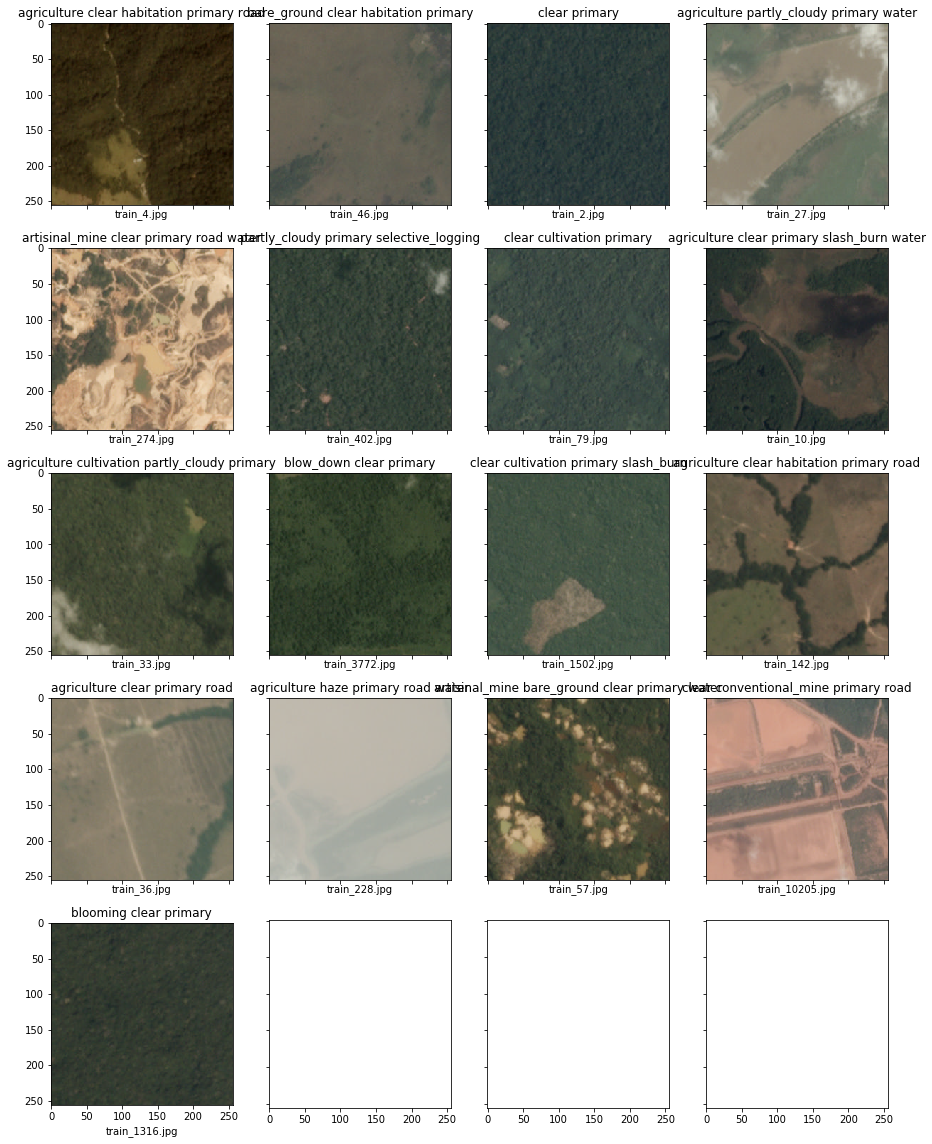

In [8]:
# Brief look at data
labels_list = list(chain.from_iterable([tags.split(" ") for tags in labels_df['tags'].values]))
labels_set = set(labels_list)
print("There are {} unique labels including {}".format(len(labels_set), labels_set))

images_title = [labels_df[labels_df['tags'].str.contains(label)].iloc[i]['image_name'] + '.jpg' 
                for i, label in enumerate(labels_set)]

labels_dict = dict()
for fn,tags in labels_df.values:
    labels_dict[fn] = tags
    
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 4, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for i, (image_name, label) in enumerate(zip(images_title, labels_set)):
    img = mpimg.imread(train_jpeg_dir + '/' + image_name)

    
    labels=labels_dict[image_name[:-4]]
    print(i, image_name, label, labels)
    axs[i].imshow(img)
    axs[i].set_title('{}'.format(labels))
    axs[i].set_xlabel('{}'.format(image_name))
plt.show()


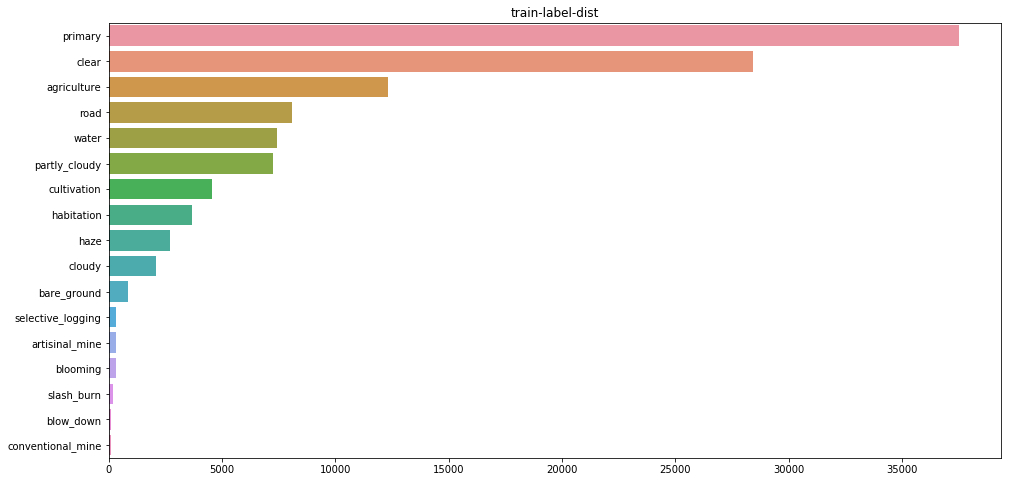

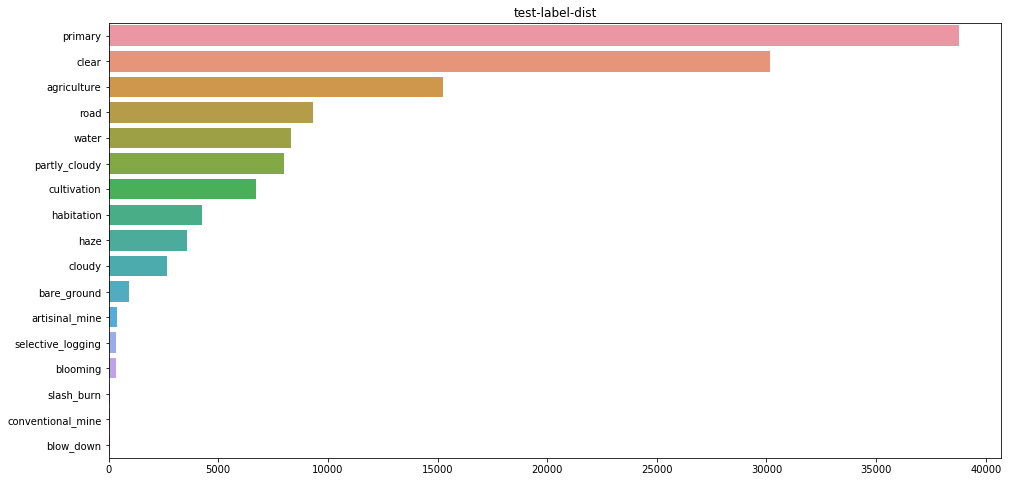

In [21]:
import plotly.graph_objs as go
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.tools as tls
from collections import Counter, defaultdict
    
# Histogram of labeled data: train/test
labels = [labels_df['tags'].apply(lambda x: x.split(' ')),
          labels_df_test['tags'].apply(lambda x: x.split(' '))]
dist_titles = ['Distribution of training labels', 'Distribution of testing labels']
cooccur_titles = ['Co-occurence matrix of training labels', 'Co-occurence matrix of testing labels']
dist_fns = ['train-label-dist', 'test-label-dist']
cooccur_fns = ['train-cooccur-matrix', 'test-cooccur-matrix']

for idx in [0,1]: # Train vs. test

    counts = defaultdict(int)
    for l in sorted(labels[idx]):
        for l2 in l:
            counts[l2] += 1

#    data=[go.Bar(x=list(counts.keys()), y=list(counts.values()))]
#    layout=dict(height=800, width=800, title=dist_titles[idx])
#    fig=dict(data=data, layout=layout)
#    py.iplot(fig, filename=dist_fns[idx])

    tags_s = pd.Series(list(chain.from_iterable(labels[idx]))).value_counts()
    fig, ax = plt.subplots(figsize=(16, 8))
    sns.barplot(x=tags_s, y=tags_s.index, orient='h');
    plt.title(dist_fns[idx])
    plt.show()

    # Co-occurrence Matrix 
    com = np.zeros([len(counts)]*2)
    for i, l in enumerate(list(counts.keys())):
        for i2, l2 in enumerate(list(counts.keys())):
            c = 0
            cy = 0
            for row in sorted(labels[idx].values):
                if l in row:
                    c += 1
                    if l2 in row: cy += 1
            com[i, i2] = cy / c

    data=[go.Heatmap(z=com, x=list(counts.keys()), y=list(counts.keys()))]
    layout=go.Layout(height=800, width=800, title=cooccur_titles[idx])
    fig=dict(data=data, layout=layout)
    py.iplot(fig, filename=cooccur_fns[idx])



In [4]:
img_resize = (128, 128, 3)

# Split data into train/validation - percentage setting
validation_split_size = 0.2

# Data preprocessing
preprocessor = Preprocessor(train_jpeg_dir, train_csv_file, test_jpeg_dir, test_csv_file,
                            img_resize[:2], validation_split_size)
preprocessor.init()

print("X_train/y_train length: {}/{}".format(len(preprocessor.X_train), len(preprocessor.y_train)))
print("X_val/y_val length: {}/{}".format(len(preprocessor.X_val), len(preprocessor.y_val)))
print("X_test/y_test length: {}/{}".format(len(preprocessor.X_test), len(preprocessor.y_test)))
preprocessor.y_map


100%|██████████| 40669/40669 [00:00<00:00, 243037.29it/s]

X_train/y_train length: 32383/32383
X_val/y_val length: 8096/8096
X_test/y_test length: 40669/40669


{0: 'agriculture',
 1: 'artisinal_mine',
 2: 'bare_ground',
 3: 'blooming',
 4: 'blow_down',
 5: 'clear',
 6: 'cloudy',
 7: 'conventional_mine',
 8: 'cultivation',
 9: 'habitation',
 10: 'haze',
 11: 'partly_cloudy',
 12: 'primary',
 13: 'road',
 14: 'selective_logging',
 15: 'slash_burn',
 16: 'water'}

## Construct the model

In [5]:
# Constructing the model
#----------------------------

mynet = MyNet(img_dim=img_resize)
mynet.model.summary()
mynet.model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics = ['accuracy'])


X_train, y_train = preprocessor.X_train, preprocessor.y_train
X_val, y_val = preprocessor.X_val, preprocessor.y_val

batch_size = 32
train_steps = len(X_train) / batch_size
val_steps = len(X_val) / batch_size

train_generator = preprocessor.get_train_generator(batch_size)
val_generator = preprocessor.get_val_generator(batch_size)


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 128, 128, 3)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 3)       12        
_________________________________________________________________
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 17)                139281    
Total params: 14,853,981
Trainable params: 14,853,975
Non-trainable params: 6
_________________________________________________________________


Epoch 1/25
1012/1011 [==============================] - 166s 164ms/step - loss: 0.1272 - acc: 0.9517 - val_loss: 0.1060 - val_acc: 0.9601

Epoch 00001: val_loss improved from inf to 0.10601, saving model to weights/weights.best.hdf5
Epoch 2/25
1012/1011 [==============================] - 166s 164ms/step - loss: 0.1029 - acc: 0.9609 - val_loss: 0.0992 - val_acc: 0.9621

Epoch 00002: val_loss improved from 0.10601 to 0.09921, saving model to weights/weights.best.hdf5
Epoch 3/25
1012/1011 [==============================] - 166s 164ms/step - loss: 0.0967 - acc: 0.9634 - val_loss: 0.0953 - val_acc: 0.9638

Epoch 00003: val_loss improved from 0.09921 to 0.09534, saving model to weights/weights.best.hdf5
Epoch 4/25
1012/1011 [==============================] - 166s 164ms/step - loss: 0.0928 - acc: 0.9648 - val_loss: 0.0922 - val_acc: 0.9652

Epoch 00004: val_loss improved from 0.09534 to 0.09224, saving model to weights/weights.best.hdf5
Epoch 5/25
1012/1011 [==============================] - 

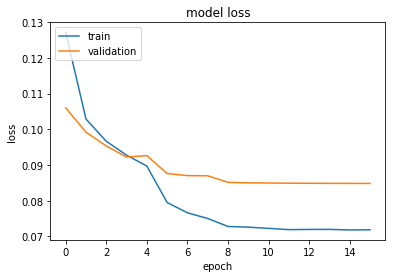

<Figure size 432x288 with 0 Axes>

In [24]:
# Train the model
#----------------------------

train_history = History()
callbacks = [train_history,
             EarlyStopping(monitor='val_loss', patience=3, verbose=1, min_delta=1e-4),
             ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=1, cooldown=0, min_lr=1e-7, verbose=1),
             ModelCheckpoint(filepath='weights/weights.best.hdf5', verbose=1, save_best_only=True,
                             save_weights_only=True, mode='auto')]

# No serious training running on Jupyter notebooks, Run EPOCH
train_history = mynet.model.fit_generator(train_generator, train_steps, epochs=25, verbose=1,
                    validation_data=val_generator, validation_steps=val_steps, callbacks=callbacks)


# ## Visualize Loss Curve

plt.plot(train_history.train_history['loss'])
plt.plot(train_history.train_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig("vgg16.losses.png")



In [6]:
# Loading trained weights
mynet.model.load_weights("weights/weights.best.hdf5")
print("Weights loaded")


Weights loaded


   ## Train the model

## Evaluate

In [7]:
predictions, x_test = mynet.predict(preprocessor, batch_size=32)
print("Predictions shape: {}\nFiles name shape: {}\n1st predictions ({}) entry:\n{}".format(predictions.shape, 
                                    x_test.shape, x_test[0], predictions[0]))

# Setting threshold for each class
thresholds = [0.2] * len(labels_set)

predicted_labels = mynet.map_predictions(preprocessor, predictions, thresholds)


1271/1270 [==============================] - 73s 58ms/step
Predictions shape: (40669, 17)
Files name shape: (40669,)
1st predictions (/work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_32950.jpg) entry:
[3.1721535e-01 1.3362360e-04 4.4692084e-02 2.2762844e-03 2.8914332e-05
 9.6300441e-01 2.0811939e-07 6.6752827e-06 9.6886414e-01 6.1915625e-02
 1.5838932e-03 1.3514871e-02 9.9996328e-01 1.2853113e-02 3.0342457e-03
 5.8064185e-02 9.0113971e-03]


NameError: name 'labels_set' is not defined

### Peep into predictions

0 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_27248.jpg ['agriculture', 'bare_ground', 'clear', 'primary'] clear primary
1 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_18087.jpg ['agriculture', 'clear', 'habitation', 'primary', 'road'] clear primary
2 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_11557.jpg ['cloudy', 'haze', 'primary'] partly_cloudy primary
3 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_2049.jpg ['clear', 'primary'] agriculture partly_cloudy primary road
4 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_13152.jpg ['clear', 'primary'] agriculture clear primary
5 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_3843.jpg ['partly_cloudy', 'primary', 'road', 'water'] clear primary
6 /work/git_repo/amazon_challenge/mlc.kaggle/input/test-jpg/test_27681.jpg ['agriculture', 'bare_ground', 'clear', 'primary', 'water'] agriculture partly_cloudy primary road water
7 /work/git_repo

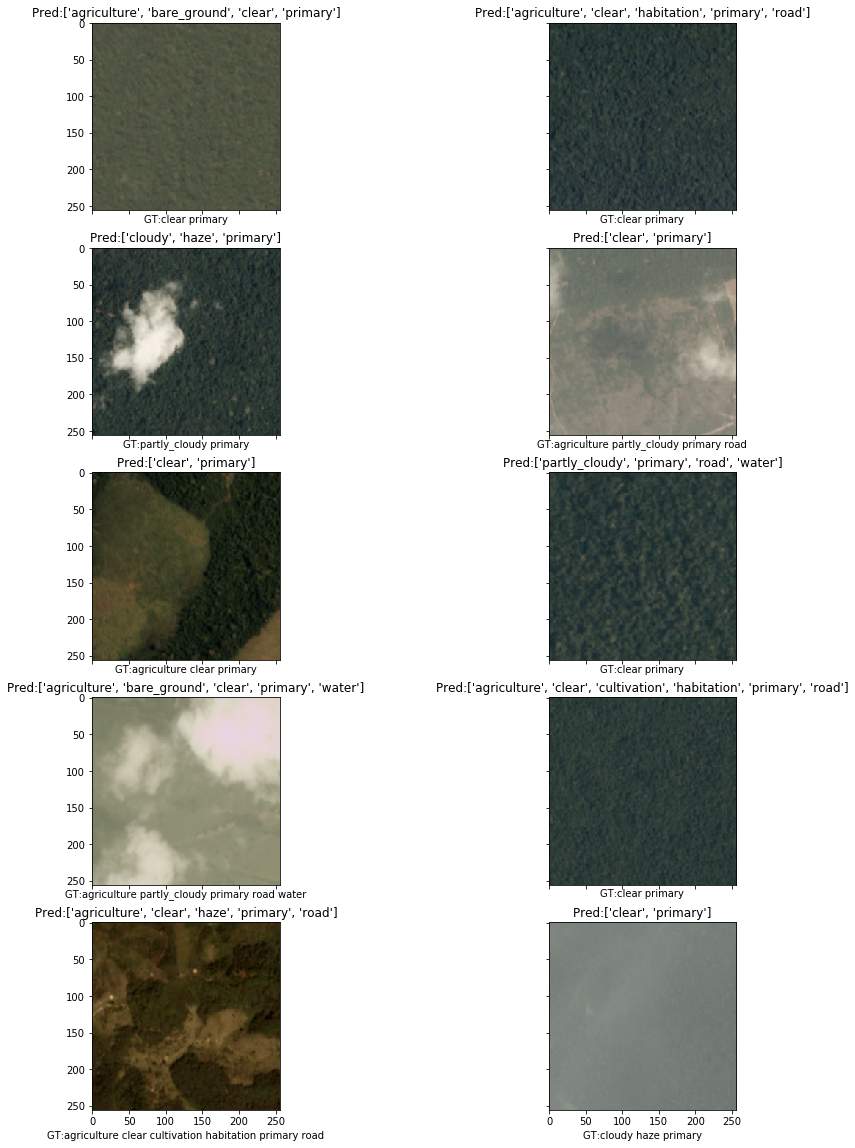

In [27]:
import re

# Look at predicted_labels vs. GT
###################################
# NO REAL GROUND TRUTH exists!!!
# Kaggle doesn't provide GT for test data.
# Used some fake ones instead. 
###################################
labels_dict_test = dict()
for fn,tags in labels_df_test.values:
    labels_dict_test[fn] = tags
    
plt.rc('axes', grid=False)
_, axs = plt.subplots(5, 2, sharex='col', sharey='row', figsize=(15, 20))
axs = axs.ravel()

for j in range(10):
    i = random.randint(0, len(predicted_labels))
    img = mpimg.imread(x_test[i])
    
    x_test_stripped = ''
    matchObj = re.match( r'.*(test_\d*).jpg.*', x_test[i])
    x_test_stripped = matchObj.group(1)

    labels=labels_dict_test[x_test_stripped]
    print(j, x_test[i], predicted_labels[i], labels)
    axs[j].imshow(img)
    axs[j].set_title('Pred:{}'.format(predicted_labels[i]))
    axs[j].set_xlabel('GT:{}'.format(labels))
plt.show()

In [10]:
import psutil

batch_size=32
print("model metrics_name:", mynet.model.metrics_names)
my_loss, my_metric = mynet.model.evaluate_generator(preprocessor._get_prediction_generator(batch_size),
                         len(preprocessor.X_test) / batch_size, workers = (psutil.cpu_count()-1))
print("my_loss=", my_loss, "my_metric=", my_metric)


model metrics_name: ['loss', 'acc']
my_loss= 0.0600320984907103 my_metric= 0.9723101521925378


In [11]:
fbeta_score = mynet.fbeta(preprocessor, mode=1)
print("fbeta_score (training data) = ", fbeta_score)

1012/1011 [==============================] - 157s 155ms/step
fbeta_score (training data) =  0.5897139493003765


In [12]:
# TODO: No thresholding applied yet! Use 0.2 as default.
fbeta_score = mynet.fbeta(preprocessor, mode=2)
print("fbeta_score (validation data) = ", fbeta_score)

253/253 [==============================] - 18s 71ms/step
fbeta_score (validation data) =  0.5818236042910084


In [31]:
##----------------------------------------
## TEST data score is expected to be low, as there NO REAL GROUND TRUTH!!!
##----------------------------------------
fbeta_score = mynet.fbeta(preprocessor)
print("fbeta_score (test data) = ", fbeta_score)

1271/1270 [==============================] - 71s 56ms/step
fbeta_score (test data) =  0.5896872505810155


In [32]:
tags_list = [None] * len(predicted_labels)
for i, tags in enumerate(predicted_labels):
    tags_list[i] = ' '.join(map(str, tags))

final_data = [[filename.split(".")[0], tags] for filename, tags in zip(x_test, tags_list)]

final_df = pd.DataFrame(final_data, columns=['image_name', 'tags'])
print("Predictions rows:", final_df.size)
final_df.head()

final_df.to_csv('../submission_file.csv', index=False)

Predictions rows: 81338


In [13]:
from sklearn.metrics import fbeta_score

preprocessor.y_map

test_img_y_prediction = np.zeros_like(preprocessor.y_test)

for i in range(len(preprocessor.X_test)):
    # Load image
    test_img_name = preprocessor.X_test[i]
    test_img_y = preprocessor.y_test[i]
    test_img_x, test_img_y = preprocessor._val_transform_to_matrices((test_img_name, test_img_y))
    # Add dimension 'batch'
    test_img_x = test_img_x.reshape(-1, 128, 128, 3)
    
    # Make prediction
    test_img_y_prediction[i] = mynet.model.predict(test_img_x)[0]
    
    # Calculate fbeta score
    #score = fbeta_score(test_img_y, test_img_y_prediction[0] > 0.2, beta=2)

    #if score < 0.8:
    #    print("filename=", test_img_name, "score=", score)

print("fbeta_avg_samples=", fbeta_score(np.array(preprocessor.y_test), test_img_y_prediction > 0.2, beta=1, average='samples'))
print("fbeta_avg_micro=", fbeta_score(np.array(preprocessor.y_test), test_img_y_prediction > 0.2, beta=1, average='micro'))
print("fbeta_avg_macro=", fbeta_score(np.array(preprocessor.y_test), test_img_y_prediction > 0.2, beta=1, average='macro'))


fbeta_avg_samples= 0.9643496042479659
fbeta_avg_micro= 0.9554434263731435
fbeta_avg_macro= 0.8274165566186976
